# 神經網路實做

## 拿取加權指數資料

In [1]:
from finlab.data import Data

data = Data()
twii = data.get("發行量加權股價指數")

twii = twii['台股指數'].resample("15T").first().dropna()
twii.head()

date
2006-01-02 09:00:00    6548.34
2006-01-02 09:15:00    6478.09
2006-01-02 09:30:00    6474.88
2006-01-02 09:45:00    6471.12
2006-01-02 10:00:00    6480.50
Name: 台股指數, dtype: float64

## 製作features

In [2]:
import talib
import numpy as np
import pandas as pd

sma = talib.SMA(twii, timeperiod=120)
wma = talib.WMA(twii, timeperiod=120)
mom = talib.MOM(twii, timeperiod=120)
k, d = talib.STOCH  (twii, twii, twii, fastk_period=120, slowk_period=60, slowd_period=60)
k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=240, slowk_period=120, slowd_period=120)
k3, d3 = talib.STOCH(twii, twii, twii, fastk_period=360, slowk_period=180, slowd_period=180)
k4, d4 = talib.STOCH(twii, twii, twii, fastk_period=480, slowk_period=240, slowd_period=240)
k5, d5 = talib.STOCH(twii, twii, twii, fastk_period=640, slowk_period=320, slowd_period=320)
k6, d6 = talib.STOCH(twii, twii, twii, fastk_period=720, slowk_period=360, slowd_period=360)
k7, d7 = talib.STOCH(twii, twii, twii, fastk_period=840, slowk_period=420, slowd_period=420)
k8, d8 = talib.STOCH(twii, twii, twii, fastk_period=960, slowk_period=480, slowd_period=480)

rsi = talib.RSI (twii, timeperiod=120)
rsi2 = talib.RSI(twii, timeperiod=240)
rsi3 = talib.RSI(twii, timeperiod=480)
rsi4 = talib.RSI(twii, timeperiod=640)
rsi5 = talib.RSI(twii, timeperiod=720)
rsi6 = talib.RSI(twii, timeperiod=840)

macd1, macd2, macd3 = talib.MACD(twii, fastperiod=120, slowperiod=60, signalperiod=60)
willr = talib.WILLR(twii, twii, twii, timeperiod=120)
cci = talib.CCI(twii, twii, twii, timeperiod=120)

dataset = pd.DataFrame({
    'RSIb': rsi / 50,
    'RSIb2': rsi2 / 50,
    'RSIb3': rsi3 / 50,
    'RSIb4': rsi4 / 50,
    'RSIb5': rsi5 / 50,
    'RSIb6': rsi6 / 50,
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    'KDb8': k8 - d8,
    
    'a5':   (twii.rolling(5).mean()   / twii),
    'a10':  (twii.rolling(10).mean()  / twii),
    'a20':  (twii.rolling(20).mean()  / twii),
    'a40':  (twii.rolling(40).mean()  / twii),
    'a80':  (twii.rolling(80).mean()  / twii),
    'a160': (twii.rolling(160).mean() / twii),
    'a320': (twii.rolling(320).mean() / twii),
    'a640': (twii.rolling(640).mean() / twii),
    'a720': (twii.rolling(720).mean() / twii),
    'a840': (twii.rolling(840).mean() / twii),
    'a960': (twii.rolling(960).mean() / twii),
    'a1024':(twii.rolling(1024).mean() / twii),
    'b1': twii/twii.shift(50),
    'b2': twii/twii.shift(100),
    'b3': twii/twii.shift(150),
    'b4': twii/twii.shift(200),
    'b5': twii/twii.shift(250),
    'b6': twii/twii.shift(300),
    'b7': twii/twii.shift(350),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(twii, 60),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(twii, 120),

    'ADXR0': talib.ADXR(twii, twii, twii, 60),
    'ADXR1': talib.ADXR(twii, twii, twii, 120),
    'ADXR2': talib.ADXR(twii, twii, twii, 240),
    'ADXR3': talib.ADXR(twii, twii, twii, 360),
    'ADXR4': talib.ADXR(twii, twii, twii, 480),
    'ADXR5': talib.ADXR(twii, twii, twii, 640),

    'return': twii.shift(-10) / twii,
})

feature_names = list(dataset.columns[:-1])

## 簡單處理一下

In [3]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)


before dropping NaN (68571, 43)
after dropping NaN (66643, 43)


In [4]:
import lightgbm as lgb
dataset_train = dataset[:'2015']

gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)

gbm.fit(dataset_train[feature_names], dataset_train['return'] > 1)


/Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 神經網路Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,RSIb,RSIb2,RSIb3,RSIb4,RSIb5,RSIb6,MOMb,KDb,KDb2,KDb3,...,b7,LINEARREG_SLOPE0,LINEARREG_SLOPE1,ADXR0,ADXR1,ADXR2,ADXR3,ADXR4,ADXR5,return
count,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,...,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,6.664300e+04,66643.000000
mean,1.277436e-16,8.332345e-16,-2.081218e-15,-1.611833e-15,-2.947419e-15,-5.157700e-15,1.858240e-16,1.690582e-17,-1.654514e-17,-6.899859e-17,...,-1.922648e-15,1.023120e-16,-5.324299e-18,3.941181e-16,1.288860e-16,4.209662e-16,-7.934405e-16,-2.607174e-16,-1.976255e-16,1.000132
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,...,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,0.008313
min,-4.430411e+00,-4.584212e+00,-4.891165e+00,-4.902955e+00,-4.882525e+00,-4.831511e+00,-1.022378e+01,-2.588044e+00,-2.684641e+00,-2.657653e+00,...,-5.440028e+00,-8.635787e+00,-7.818834e+00,-2.110713e+00,-1.961033e+00,-1.733588e+00,-1.659141e+00,-1.791093e+00,-1.925458e+00,0.924507
25%,-6.886745e-01,-6.892701e-01,-6.742066e-01,-6.649846e-01,-6.616835e-01,-6.493217e-01,-4.804277e-01,-6.430756e-01,-6.503126e-01,-6.288562e-01,...,-5.137208e-01,-4.898317e-01,-4.929649e-01,-7.369820e-01,-7.037247e-01,-7.483212e-01,-7.014938e-01,-6.910563e-01,-7.063699e-01,0.997045
50%,9.244996e-02,1.214734e-01,1.210136e-01,1.254195e-01,1.321886e-01,1.405660e-01,1.045689e-01,-1.190962e-02,-2.868697e-02,-7.644799e-03,...,1.239997e-01,8.327921e-02,9.285898e-02,-1.615794e-01,-2.333086e-01,-2.557205e-01,-2.356834e-01,-2.091704e-01,-1.900612e-01,1.000267
75%,7.277285e-01,7.207806e-01,6.968363e-01,7.058210e-01,7.073666e-01,7.062299e-01,6.067779e-01,6.552202e-01,6.709389e-01,5.987108e-01,...,5.641709e-01,5.884410e-01,6.044658e-01,5.984458e-01,4.843849e-01,5.008526e-01,4.767138e-01,4.439972e-01,5.531497e-01,1.003655
max,2.890788e+00,2.840481e+00,2.911296e+00,2.921670e+00,2.915377e+00,2.899779e+00,4.839249e+00,2.729909e+00,2.591726e+00,2.549347e+00,...,4.823699e+00,5.431553e+00,4.561873e+00,4.554255e+00,4.173653e+00,3.976500e+00,3.519582e+00,3.539684e+00,3.567033e+00,1.087726


In [6]:
import tqdm

n = 3

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled['return'].iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])
#dataset_scaled.head()

/Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [7]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [8]:
indexes = np.array(indexes)

## 神經網路 Model

In [ ]:
import keras

model = keras.models.Sequential()
#model.add(keras.layers.Dense(100, activation="relu", input_shape=(len(feature_names),)))
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=X[0].shape))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1,kernel_initializer="uniform",activation='linear'))

adam = keras.optimizers.Adam(0.0006)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

## 神經網路訓練

In [10]:
# dataset_scaled_train = dataset_scaled[:'2015']

import datetime
X_train = X[indexes < datetime.datetime(2016, 1, 1)]
y_train = y[indexes < datetime.datetime(2016, 1, 1)]


get_best_model = keras.callbacks.ModelCheckpoint("lstm.mdl", monitor="val_acc")

history = model.fit(
    X_train,  
    y_train > 1, 
    batch_size=5000, 
    epochs=300, 
    validation_split=0.2, 
    callbacks=[get_best_model])

W1229 12:51:48.225897 4465829312 deprecation_wrapper.py:119] From /Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 36175 samples, validate on 9044 samples
Epoch 1/300
36175/36175 [==============================] - 6s 178us/step - loss: 4.2905 - acc: 0.4798 - val_loss: 2.4428 - val_acc: 0.5036
Epoch 2/300
36175/36175 [==============================] - 3s 72us/step - loss: 2.3138 - acc: 0.4798 - val_loss: 2.0428 - val_acc: 0.5036
Epoch 3/300
36175/36175 [==============================] - 3s 93us/step - loss: 1.9934 - acc: 0.4798 - val_loss: 1.8770 - val_acc: 0.5036
Epoch 4/300
36175/36175 [==============================] - 3s 86us/step - loss: 1.8508 - acc: 0.4798 - val_loss: 1.7717 - val_acc: 0.5036
Epoch 5/300
36175/36175 [==============================] - 3s 89us/step - loss: 1.7485 - acc: 0.4798 - val_loss: 1.6867 - val_acc: 0.5036
Epoch 6/300
36175/36175 [==============================] - 3s 84us/step - loss: 1.6600 - acc: 0.4798 - val_loss: 1.6087 - val_acc: 0.5036
Epoch 7/300
36175/36175 [==============================] - 3s 83us/step - loss: 1.5749 - acc: 0.4798 - val_loss: 1.5323 - 

KeyboardInterrupt: 

In [12]:
model.load_weights("lstm.mdl")

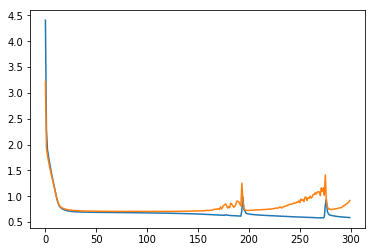

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## 回測

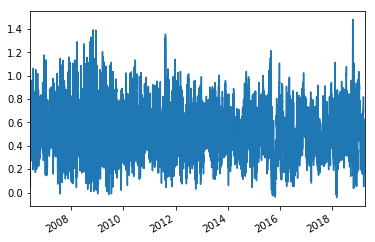

In [14]:
ey = model.predict(X)
ey = pd.Series(ey.swapaxes(0,1)[0], index=indexes)
ey.plot()


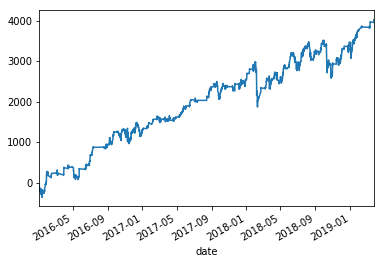

In [15]:
eq = twii[indexes]
returns = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.6)).rolling(10).sum() > 0
signal = signal.shift(1).fillna(False)

eq = (returns[signal]['2016':]).cumsum()
eq.plot()

In [16]:
(signal.astype(int).diff().abs().fillna(0) * 3)['2016':].sum()

675.0